# Project for **Introduction to Image Processing - 4TTV414U**

* **Date**: 16 May 2023

* **Name**: Koutsonikolis Nikolaos

* **Description of the project**: The project is broken down into **3 parts**. For the first part we need to compute a disparity map(given 2 stereo images as input), I actually computed 2 disparity maps because I couldn't select which algorithm did the best job, and also to be able to compare the last part's results using these two disparity maps. Moving on to the second part we had to compute 2 depth maps using 2 different Deep Neural Networks. For the last part we had to pass the previously generated maps/images through a high-pass filter and see if we can get better results in terms of edge detection. Again I used 2 different filters so I could compare the results.

* **What I have used for my implementation**: [StereoBM](https://docs.opencv.org/3.4/d9/dba/classcv_1_1StereoBM.html) and [StereoSGBM](https://docs.opencv.org/3.4/d2/d85/classcv_1_1StereoSGBM.html) block-matching algorithms to compute the disparity maps, **MiDaS_DPT_Large** pretrained model for monocular depth estimation(depth map #1), **DenseDepth** pretrained model on the [NYU-Depth V2 dataset](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html) for monocular depth estimation(depth map #2), Laplacian and Sobel convulution filters for edge detection.


> *Special thanks to the creators of [DenseDepth](https://github.com/ialhashim/DenseDepth.git) and [MiDaS](https://github.com/isl-org/MiDaS.git) models*


# Part 1 - Classic Disparity Maps

Firstly we import the required libraries

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

Then we load our stereo images(left/right)

In [2]:
from google.colab import files

uploaded = files.upload()

Saving im0.png to im0.png
Saving im1.png to im1.png


💡 Loading them in grayscale is better in terms of resource/time efficiency when creating the disparity map

In [3]:
# left image
stereo_l = cv2.imread("im0.png", cv2.IMREAD_GRAYSCALE)

# right image
stereo_r = cv2.imread("im1.png", cv2.IMREAD_GRAYSCALE)

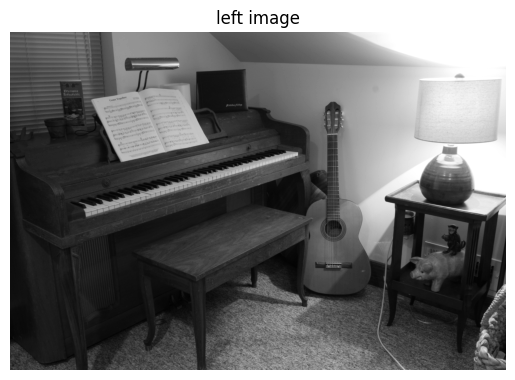

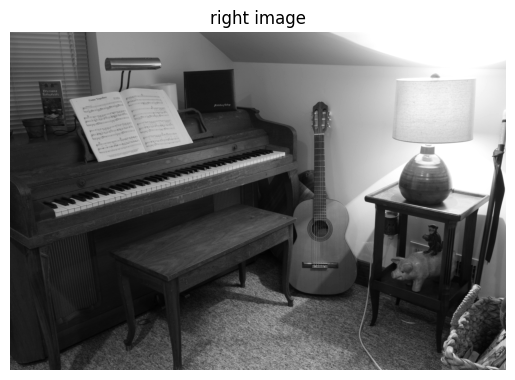

In [4]:
plt.imshow(stereo_l, 'gray')
plt.axis('off')
plt.title("left image")
plt.show()

plt.imshow(stereo_r, 'gray')
plt.title("right image")
plt.axis('off')
plt.show()

**Block Matching Algorithms**

Create our disparity maps.<br>
I could not decide which algorithm does a better job in our case, so I have implemented both methods here.<br>
I also tried lots of different combinations but I ended up with these as the "best results".

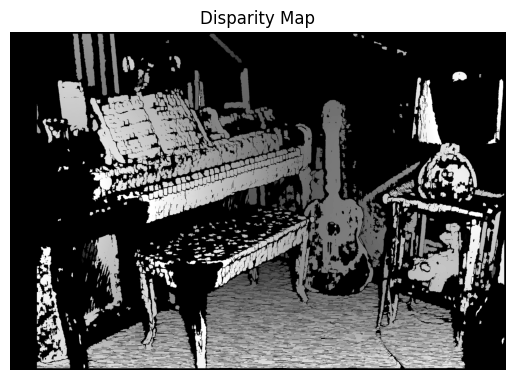

In [ ]:
## StereoBM algorithm
stereo = cv2.StereoBM_create()

stereo.setNumDisparities(128)
stereo.setBlockSize(21)
stereo.setSpeckleRange(1)
stereo.setSpeckleWindowSize(100)
stereo.setMinDisparity(16)

# compute disparities & normalization
disparity_BM = stereo.compute(stereo_l,stereo_r).astype(np.float32) / 16.0

plt.imshow(disparity_BM, 'gray')
plt.title("Disparity Map")
plt.axis("off")
plt.show()

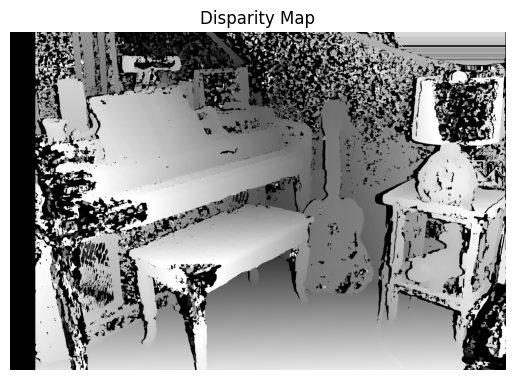

In [ ]:
# StereoSGBM algorithm
stereo = cv2.StereoSGBM_create(minDisparity = 16,
                              numDisparities=128,
                              blockSize=23,
                              speckleWindowSize = 100,
                              speckleRange = 1)

disparity_SGBM = stereo.compute(stereo_l,stereo_r).astype(np.float32) / 16.0

plt.imshow(disparity_SGBM, 'gray')
plt.title("Disparity Map")
plt.axis("off")
plt.show()

Save our disparity maps

In [ ]:
disparity_BM = cv2.cvtColor(disparity_BM, cv2.COLOR_GRAY2RGB)
disparity_SGBM = cv2.cvtColor(disparity_SGBM, cv2.COLOR_GRAY2RGB)

In [ ]:
cv2.imwrite('disparity_bm.png', disparity_BM)
cv2.imwrite('disparity_sgbm.png', disparity_SGBM)

True

💡 For the next part I will be using the left image as input

# Part 2 - MiDaS

**Implementing the MiDaS pretrained model**

I will be using **DPT_Large** which is based on a **Vision Transformer(ViT) for Dense Prediction**. This is the largest MiDaS model, has best accuracy but is slower. There also exists the **DPT_Hybrid** model(also transformer model) with lower accuracy but faster execution time, and finally the **DPT_Small** which is the legacy MiDaS model based on CNNs.

For more information on the model: [DPT-Large](https://huggingface.co/Intel/dpt-large)

In [ ]:
!pip install timm

In [ ]:
import torch

In [ ]:
model_type = "DPT_Large"

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
# accelerate the gpu if possible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
# load image
test_img = cv2.imread('im0.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# create batch
input_batch = transform(test_img).to(device)

In [ ]:
# predict on the model
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=test_img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

# get the depth map(prediction)
output_large = prediction.cpu().numpy()

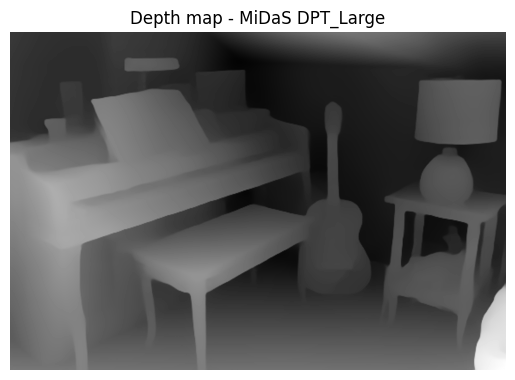

In [ ]:
# plot the depth map
plt.imshow(output_large, 'gray')
plt.title("Depth map - MiDaS DPT_Large")
plt.axis('off')
plt.show()

Save the depth map in grayscale

In [ ]:
plt.imsave('midas_large_gray.png',output_large)

In [ ]:
midas = cv2.imread('midas_large_gray.png', cv2.IMREAD_GRAYSCALE)
cv2.imwrite('midas_large_gray.png',midas)

True



# Part 2 - DenseDepth

**Implementing the DenseDepth pretrained model**

I will be using the **nyu.h5** pretrained model from DenseDepth. There is also another pretrained alternative of the DenseDepth trained on the **KITTI** depth dataset. DenseNet is basically a U-Net and its encoder is based on the **DenseNet-169 architecture**.

For more information on the DenseNet: [Official Paper](https://arxiv.org/pdf/1812.11941.pdf)

In [ ]:
!wget https://github.com/ialhashim/DenseDepth/archive/refs/heads/master.zip

--2023-05-16 14:49:49--  https://github.com/ialhashim/DenseDepth/archive/refs/heads/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ialhashim/DenseDepth/zip/refs/heads/master [following]
--2023-05-16 14:49:50--  https://codeload.github.com/ialhashim/DenseDepth/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [     <=>            ]  11.76M  10.2MB/s    in 1.1s    

2023-05-16 14:49:51 (10.2 MB/s) - ‘master.zip’ saved [12332092]



In [ ]:
!unzip master.zip

In [ ]:
!rm master.zip

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=19dfvGvDfCRYaqxVKypp1fRHwK7XtSjVu' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19dfvGvDfCRYaqxVKypp1fRHwK7XtSjVu" -O nyu.h5 && rm -rf /tmp/cookies.txt

--2023-05-16 14:50:05--  https://docs.google.com/uc?export=download&confirm=t&id=19dfvGvDfCRYaqxVKypp1fRHwK7XtSjVu
Resolving docs.google.com (docs.google.com)... 74.125.24.138, 74.125.24.139, 74.125.24.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-88-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e1kecmc75ihp63vo7rom3pfn6bpqio13/1684248600000/00066789881306885574/*/19dfvGvDfCRYaqxVKypp1fRHwK7XtSjVu?e=download&uuid=9e0e0c38-e729-4f99-92d7-306781260b0e [following]
--2023-05-16 14:50:05--  https://doc-0g-88-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e1kecmc75ihp63vo7rom3pfn6bpqio13/1684248600000/00066789881306885574/*/19dfvGvDfCRYaqxVKypp1fRHwK7XtSjVu?e=download&uuid=9e0e0c38-e729-4f99-92d7-306781260b0e
Resolving doc-0g-88-docs.googleusercontent.com (doc-0g-88-docs.googleusercontent.com)... 142.251.12.132, 2404

In [ ]:
!mv DenseDepth-master/* .

In [ ]:
!rmdir DenseDepth-master

In [ ]:
# load and resize the image(doesn't work with large images)
test_img = cv2.imread('im0.png')
test_img = cv2.resize(test_img, (640,480))
cv2.imwrite('im0_res.png',test_img)

True

run the script to predict on our image

In [ ]:
!python test.py --input im0_res.png

Loading model...

Model loaded (nyu.h5).

Loaded (1) images of size (480, 640, 3).
1/1 [==============================] - 7s 7s/step
/content/utils.py:77: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return skimage.util.montage(all_images, multichannel=True, fill=(0,0,0))


💡 I had to do some modifications in the **test.py** file so I could only save the output image and not a figure of input/output which is the default(that's dumb anyways..)

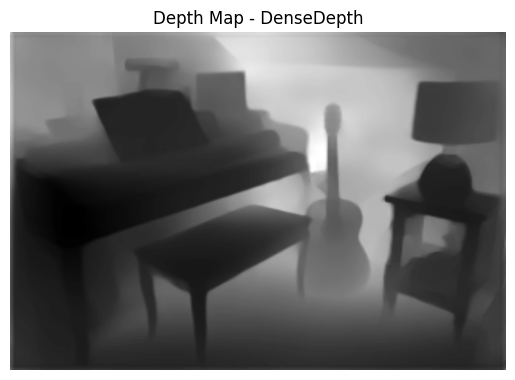

In [ ]:
densedepth = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE) # open in grayscale
densedepth = cv2.resize(densedepth, (2820,1920)) # resize back to original dimensions
cv2.imwrite("densedepth.png", densedepth) # save

plt.imshow(densedepth, 'gray')
plt.title('Depth Map - DenseDepth')
plt.axis('off')
plt.show()

# Time for a small debrief - Depth maps

Although we are comparing two really different models, one based on transformers and the second based on CNNs(basically being a common U-net), both of them are much powerful in estimating a pretty accurate depth map out of a single image, thus **monocular depth estimation**. The difference between these two depth maps is mostly about the way the depth map is represented.<br>
* MiDaS depth ~> brighter closer objects<br>
* DenseDepth depth ~> darker closer objects with a *fog effect*<br>

I think at least for our example, that MiDaS has done a better job. The details are not so visible and the objects are kind of neutralized, but we have a smoother output, not great loss of information, things that are closer to the camera appear brighter than the rest, so we can actually perceive the different depth planes.

# Part 3 - Edge Detection using High-Pass filters

In [ ]:
# IGNORE THIS
# this is just to remember the names of the files:)

########################
#   generated images   #
########################

#disparity_bm.png
#disparity_sgbm.png
#midas_large_gray.png
#midas_large_rgb.png
#densedepth.png

In [ ]:
# read them all in grayscale
img_bm = cv2.imread("disparity_bm.png", cv2.IMREAD_GRAYSCALE)
img_sgbm = cv2.imread("disparity_sgbm.png", cv2.IMREAD_GRAYSCALE)
img_midas = cv2.imread("midas_large_gray.png", cv2.IMREAD_GRAYSCALE)
img_dense = cv2.imread("densedepth.png", cv2.IMREAD_GRAYSCALE)

**Plotting the images we have so far**
1. Original image(left)
2. Stereo BM disparity
3. Stereo SGBM disparity
4. MiDaS depth
5. DanseDepth depth

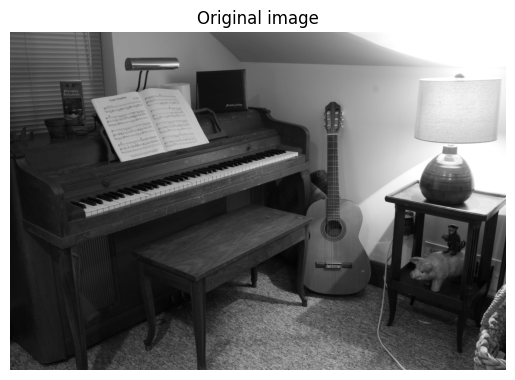

In [ ]:
# this is the left image - the one we used to make the depth maps
plt.imshow(stereo_l, 'gray')
plt.title('Original image')
plt.axis('off')
plt.show()

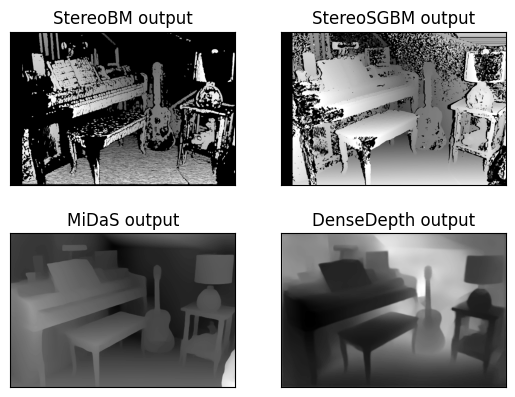

In [ ]:
plt.subplot(2,2,1),plt.imshow(img_bm, 'gray')
plt.title('StereoBM output'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(img_sgbm, 'gray')
plt.title('StereoSGBM output'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(img_midas, 'gray')
plt.title('MiDaS output'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(img_dense , 'gray')
plt.title('DenseDepth output'), plt.xticks([]), plt.yticks([])

plt.show()

**Implementing the Laplacian convolution filter**

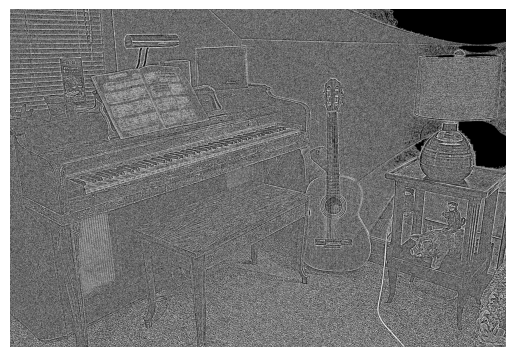

In [ ]:
# First we use the laplacian filter on our original image
laplacian = cv2.Laplacian(stereo_l, cv2.CV_64F)
plt.imshow(laplacian.astype(np.uint8),'gray')
plt.axis('off')
plt.show()

As it seems there is much noise so obviously the desired result would be one less noisy, emphasizing on the edges/contours.

Now let's apply the Laplacian filter to every previously generated image(disparity maps, depth maps).

In [ ]:
laplacian_bm = cv2.Laplacian(img_bm, cv2.CV_64F)
laplacian_sgbm = cv2.Laplacian(img_sgbm, cv2.CV_64F)
laplacian_midas = cv2.Laplacian(img_midas, cv2.CV_64F)
laplacian_dense = cv2.Laplacian(img_dense, cv2.CV_64F)

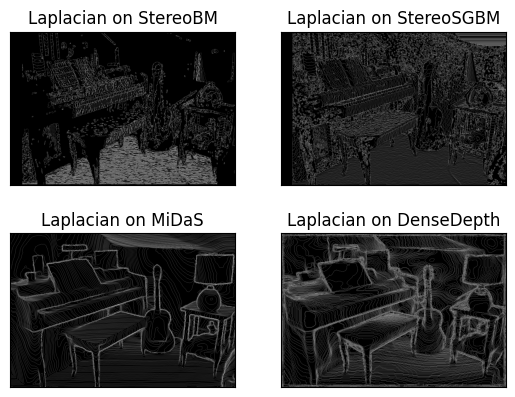

In [ ]:
plt.subplot(2,2,1),plt.imshow(laplacian_bm.astype(np.uint8),'gray')
plt.title('Laplacian on StereoBM'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian_sgbm.astype(np.uint8),'gray')
plt.title('Laplacian on StereoSGBM'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(laplacian_midas.astype(np.uint8),'gray')
plt.title('Laplacian on MiDaS'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(laplacian_dense.astype(np.uint8),'gray')
plt.title('Laplacian on DenseDepth'), plt.xticks([]), plt.yticks([])

plt.show()

**Implementing the Sobel convolution filter**

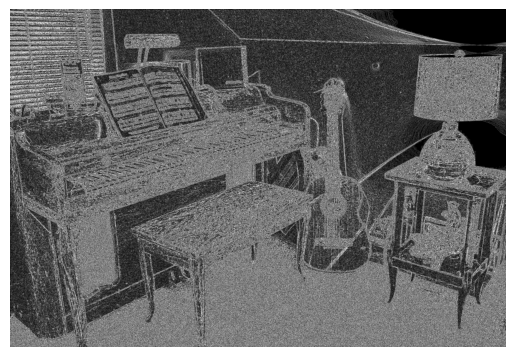

In [ ]:
# Firstly apply the sobel filter to our original image

# horizontal
sobelx_original = cv2.Sobel(stereo_l, cv2.CV_64F, 1, 0, ksize=5)

# vertical
sobely_original = cv2.Sobel(stereo_l, cv2.CV_64F, 0, 1, ksize=5)

# A Combined Sobel filter(x axis and y axis) can be achieved
# by taking the square root of sum of squares
# of the horizontal and vertical sobel filters
sobelxy_original = np.sqrt(np.square(sobelx_original) + np.square(sobely_original))

plt.imshow(sobelxy_original.astype(np.uint8),'gray')
plt.axis('off')
plt.show()

Again, there is much noise when we use the original image.

Now let's apply the Sobel filters to every generated image.<br>
Primarily, the x and y filters so we can then create the combined one.

💡<br> 
**Sobel_x** refers to the horizontal sobel filter.<br>
**Sobel_y** refers to the vertical sobel filter.<br>
**ksize** refers to the kernel size i.e. ksize = 5 means 5x5 filter.


In [ ]:
sobelx_bm = cv2.Sobel(img_bm, cv2.CV_64F,1,0,ksize=5)
sobelx_sgbm = cv2.Sobel(img_sgbm, cv2.CV_64F,1,0,ksize=5)
sobelx_midas = cv2.Sobel(img_midas, cv2.CV_64F,1,0,ksize=5)
sobelx_dense = cv2.Sobel(img_dense, cv2.CV_64F,1,0,ksize=5)

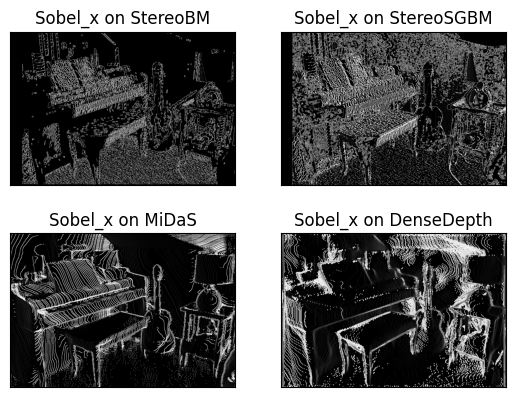

In [ ]:
plt.subplot(2,2,1),plt.imshow(sobelx_bm.astype(np.uint8),'gray')
plt.title('Sobel_x on StereoBM'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(sobelx_sgbm.astype(np.uint8),'gray')
plt.title('Sobel_x on StereoSGBM'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx_midas.astype(np.uint8),'gray')
plt.title('Sobel_x on MiDaS'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobelx_dense.astype(np.uint8),'gray')
plt.title('Sobel_x on DenseDepth'), plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
sobely_bm = cv2.Sobel(img_bm, cv2.CV_64F,0,1,ksize=5)
sobely_sgbm = cv2.Sobel(img_sgbm, cv2.CV_64F,0,1,ksize=5)
sobely_midas = cv2.Sobel(img_midas, cv2.CV_64F,0,1,ksize=5)
sobely_dense = cv2.Sobel(img_dense, cv2.CV_64F,0,1,ksize=5)

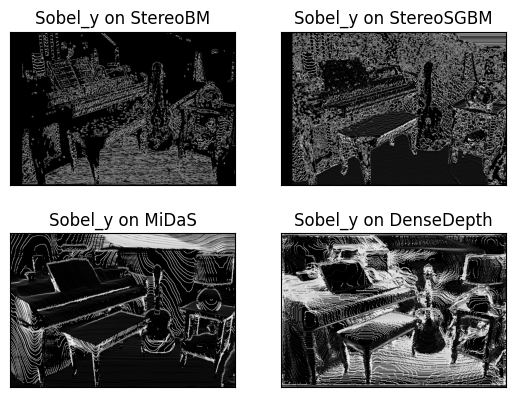

In [ ]:
plt.subplot(2,2,1),plt.imshow(sobely_bm.astype(np.uint8), 'gray')
plt.title('Sobel_y on StereoBM'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(sobely_sgbm.astype(np.uint8), 'gray')
plt.title('Sobel_y on StereoSGBM'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobely_midas.astype(np.uint8), 'gray')
plt.title('Sobel_y on MiDaS'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely_dense.astype(np.uint8), 'gray')
plt.title('Sobel_y on DenseDepth'), plt.xticks([]), plt.yticks([])

plt.show()

Now for the Combined Sobel filter:

![image.png](https://miro.medium.com/v2/resize:fit:828/format:webp/1*dY_BnICdMcnm9eyu9p7zwQ.png)

We actually create a new image with the same dimensions as before, but as "pixel data" the new image will contain the **magnitude** of the two gradients(x and y), given as the **square root of sums of squares of the gradients**.

In [ ]:
sobelxy_bm = np.sqrt(np.square(sobelx_bm) + np.square(sobely_bm))
sobelxy_sgbm = np.sqrt(np.square(sobelx_sgbm) + np.square(sobely_sgbm))
sobelxy_midas = np.sqrt(np.square(sobelx_midas) + np.square(sobely_midas))
sobelxy_dense = np.sqrt(np.square(sobelx_dense) + np.square(sobely_dense))

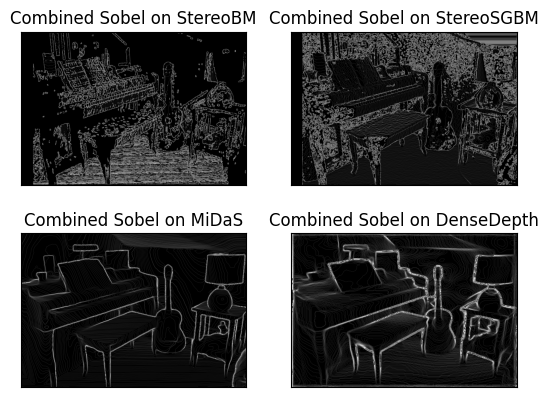

In [ ]:
plt.subplot(2,2,1),plt.imshow(sobelxy_bm.astype(np.uint8),'gray')
plt.title('Combined Sobel on StereoBM'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(sobelxy_sgbm.astype(np.uint8),'gray')
plt.title('Combined Sobel on StereoSGBM'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelxy_midas.astype(np.uint8),'gray')
plt.title('Combined Sobel on MiDaS'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobelxy_dense.astype(np.uint8),'gray')
plt.title('Combined Sobel on DenseDepth'), plt.xticks([]), plt.yticks([])

plt.show()

# Time for a small debrief #2 - High-pass filters

It is obvious, as we found out from our tests, that applying these high-pass filters directly on our images **do not** produce a high quality result. There is a lot of noise and we actually miss almost every edge-related detail. On the contrary, we need these specific details so we can identify the edges, the outlines, the contours of the objects.

The use of the generated disparity and depth maps, meaning the ones that we previously created, seem to be of a help for this particular task. While all of them have better results than the actual image, the disparity maps still do not produce a good result. That is mostly because of the noise that they contain, due to occlusions or plain textures and/or because they are not so accurate.<br>
Ideally, the better the disparity map ~> the better the result produced by the filter

On the other hand, depth maps appear to have way better results. We can actually take a look below:

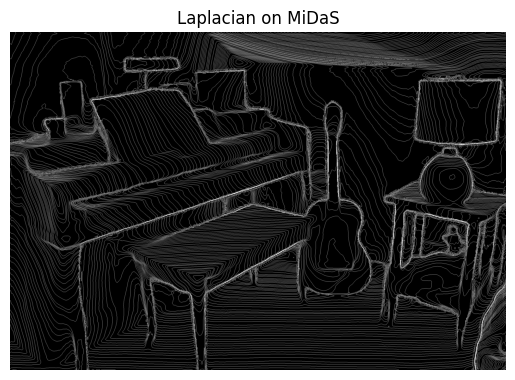

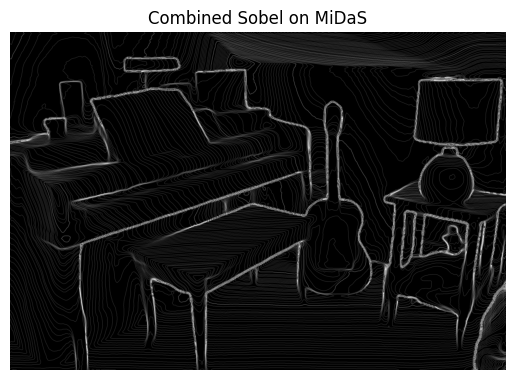

In [ ]:
# Laplacian on MiDaS
plt.imshow(laplacian_midas.astype(np.uint8),'gray')
plt.title('Laplacian on MiDaS')
plt.axis('off')
plt.show()

# Sobel on MiDaS
plt.imshow(sobelxy_midas.astype(np.uint8),'gray')
plt.title('Combined Sobel on MiDaS')
plt.axis('off')
plt.show()

Even if the noise itself is not completely extinct, the outcome of the filters on the depth maps is **way way better** than that of the original image and the disparity maps. That is because the depth maps provide a less noisy input for our filters, more precise representation of the objects in the image, the limits/borders of each object are clearer.<br>
In fact, this could possibly contribute in image preparation before carrying out certain tasks i.e. better edge detection for improved image segmentation.

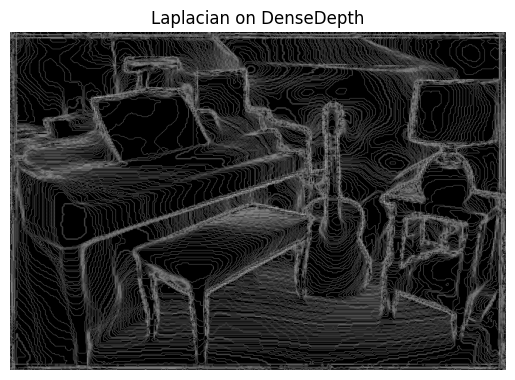

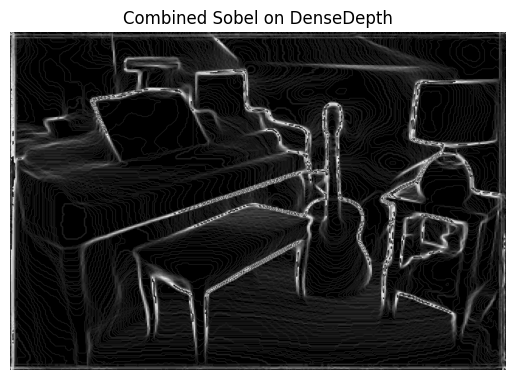

In [ ]:
# Laplacian on DenseDepth
plt.imshow(laplacian_dense.astype(np.uint8),'gray')
plt.title('Laplacian on DenseDepth')
plt.axis('off')
plt.show()

# Sobel on DenseDepth
plt.imshow(sobelxy_dense.astype(np.uint8),'gray')
plt.title('Combined Sobel on DenseDepth')
plt.axis('off')
plt.show()

Both for MiDaS and DenseDepth, the Sobel filter seems to have better results than the Laplacian one, and between these two depth maps, I think that MiDaS brought the optimal outcome. However, this is really something subjective at this point. There are also other factors to consider. For instance, playing with the models/algorithms a little bit may improve the results. Also, considering about what the context is and where we want to end up(thinking about accuracy, time/resource cost e.t.c) may help us deciding what to finally use and provide us with a solid solution.

To sum up, I believe that the results are really good and the use of depth maps can certainly help improving this edge detection significantly.